# Analyse exploratoire de la base de données du site d'e-commerce Olist

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
import datetime
#import plotly.express as px

In [2]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
    """Calculate distance between two points with Haversine methods
    source : https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/"""

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [3]:
sns.set_palette("Pastel2")

Le site d'e-commerce Olist a fourni un ensemble de datasets pour pouvoir effectuer une segmentation de ces clients. Ci-dessous le schéma expliquant le fonctionnement de ces fichiers.
<img src="MCD.png">

## 1 - Analyses des données en lien avec les clients

In [4]:
# Importation 
df_customers = pd.read_csv("datasets/olist_customers_dataset.csv")
df_geo = pd.read_csv("datasets/olist_geolocation_dataset.csv")

In [5]:
df_customers = pd.merge(df_geo, df_customers,
                        right_on=["customer_zip_code_prefix", "customer_city", "customer_state"], 
                        left_on=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[['customer_id', "customer_unique_id", "customer_zip_code_prefix", "customer_city", "customer_state", "geolocation_lat", "geolocation_lng"]]
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.497396,-47.399241
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.510459,-47.399553
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.480940,-47.394161
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.515413,-47.398194


On a assemblé les données des clients avec les données de géolocalisation. On va pouvoir étudier la distribution des clients à travers le pays. 

In [6]:
df_customers.isnull().mean()

customer_id                 0.000000
customer_unique_id          0.000000
customer_zip_code_prefix    0.000000
customer_city               0.000000
customer_state              0.000000
geolocation_lat             0.000023
geolocation_lng             0.000023
dtype: float64

In [7]:
df_customers.drop_duplicates(subset=['customer_unique_id'], inplace=True)

Il y a quelque valeurs manquantes en ce qui concerne les coordonnées de géolocalisation de nos clients. On supprime les données dupliquées du dataset. 

In [8]:
df_customers.shape

(96096, 7)

### Description de l'origine des clients

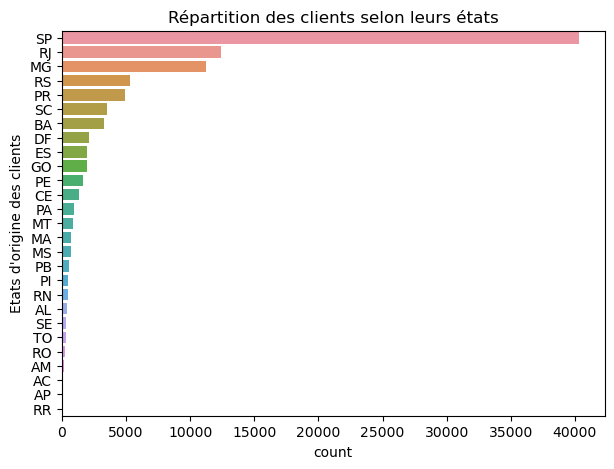

In [9]:
plt.figure(figsize=(7,5))
sns.countplot(y="customer_state", data=df_customers, order=df_customers["customer_state"].value_counts().index)
plt.title("Répartition des clients selon leurs états")
plt.ylabel("Etats d'origine des clients")
plt.show()

Un grand nombre de nos clients vit dans l'état de Sao Paolo. Il s'agit de l'état le plus peuplé du Brésil. Il pourrait être intéressant de faire un calcul en pondérant le nombre de clients sur le nombre d'habitants dans les différents états brésiliens. 

SP : Sao Paolo, MG : Minas Gerais, RJ : Rio de Janeiro, RS : Rio Grande do Sul, PR : Paranà, SC : Santa Catarina, BA : Bahia, ES : Espírito Santo, GO : Goias, MT : Mato Grosso, PE : Pernambuco, PA : Parà, DF : Distrito Federal, CE : Cearà, MS : Mato Grosso do Sul, MA : Maranhão, AL : Alagoas, PB : Paraíba, PI : Piauí, SE : Sergipe, RN : Rio Grande do Norte, RO : Rondônia, TO : Tocantins, AC : Acre, AM : Amazonas, AP : Amapá, RR : Roraima.

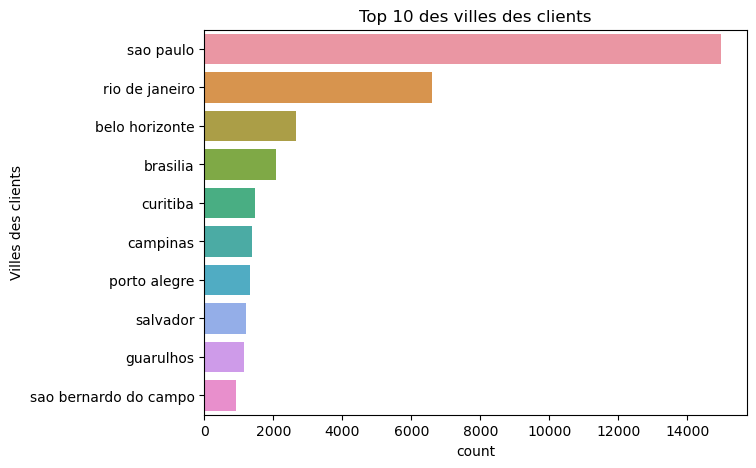

In [10]:
plt.figure(figsize=(7,5))
sns.countplot(y="customer_city", data=df_customers, order=df_customers["customer_city"].value_counts().index[:10])
plt.title("Top 10 des villes des clients")
plt.ylabel("Villes des clients")
plt.show()

La majorité des clients vivent à Rio de Janeiro. Il s'agit de la seconde ville la plus peuplée du Brésil. Elle possède 8% de la population du pays. On observe qu'ensuite les clients vivent à Sao Paolo, qui est la ville la plus peuplée du pays. Enfin, en troisième position, on retrouve Belo Horizonte. Cette ville se situe dans l'état de Minas Gerais. 

In [11]:
print("Nombre d'id customer :", df_customers["customer_id"].nunique())

Nombre d'id customer : 96096


In [12]:
print("Nombre d'id customer unique:", df_customers["customer_unique_id"].nunique())

Nombre d'id customer unique: 96096


On observe une différence de 3000 id clients entre les id unique et les id clients. Il va falloir faire un choix entre la conservation des id unique ou les id seuls. 

In [13]:
print("Nombre de villes:", df_customers["customer_city"].nunique())

Nombre de villes: 4118


Les clients se répartissent dans 4118 villes. Le Brésil compte 5570 villes. 

fig = px.scatter_mapbox(df_geo, lat="geolocation_lat", lon="geolocation_lng", color="geolocation_state",
                        zoom=1.5, height=500)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## 2 - Analyses des commandes

In [14]:
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")
df_orders_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv")
df_review = pd.read_csv("datasets/olist_order_reviews_dataset.csv")
df_order_items = pd.read_csv("datasets/olist_order_items_dataset.csv")

In [15]:
df_orders = pd.merge(df_orders, df_orders_payments, on ="order_id", how="left")
df_orders = pd.merge(df_orders, df_review, on="order_id", how="left")
df_orders = pd.merge(df_orders, df_order_items, on="order_id", how="left")
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,...,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,...,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


On a crée un dataset unique avec les différentes informations sur les commandes. Ainsi, on peut voir le statut des commandes, les dates d'achat, les dates d'enlèvement chez le vendeur, les dates de livraisons, les dates estimées de livraisons, le nombre de paiements pour une commande, le type de payments, les scores sur les commandes, la valeur de la commande et les frais d'envoi. 

### Recherche de données manquantes et dupliquées

In [16]:
df_orders.isnull().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001486
order_delivered_carrier_date     0.017507
order_delivered_customer_date    0.028711
order_estimated_delivery_date    0.000000
payment_sequential               0.000025
payment_type                     0.000025
payment_installments             0.000025
payment_value                    0.000025
review_id                        0.000000
review_score                     0.000000
review_comment_title             0.880916
review_comment_message           0.569874
review_creation_date             0.000000
review_answer_timestamp          0.000000
order_item_id                    0.006991
product_id                       0.006991
seller_id                        0.006991
shipping_limit_date              0.006991
price                            0.006991
freight_value                    0

In [17]:
df_orders.shape

(119151, 24)

In [18]:
df_orders["order_id"].nunique()

99441

On observe qu'il y a un grand nombre de données manquantes pour les titres et les messages donnant un avis sur la commande. On a un nombre moins important de valeurs manquantes pour les variables en lien avec la livraison. 

In [19]:
df_orders.drop_duplicates(subset="order_id", keep="last", inplace=True)

### Description des variables en lien avec les commandes

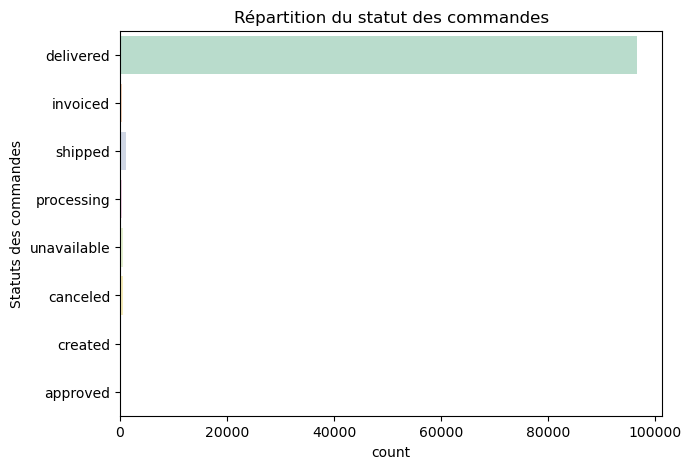

In [20]:
plt.figure(figsize=(7, 5))
sns.countplot(y="order_status", data=df_orders)
plt.title("Répartition du statut des commandes")
plt.ylabel("Statuts des commandes")
plt.show()

La plupart des commandes sont au statut "Réceptionné".

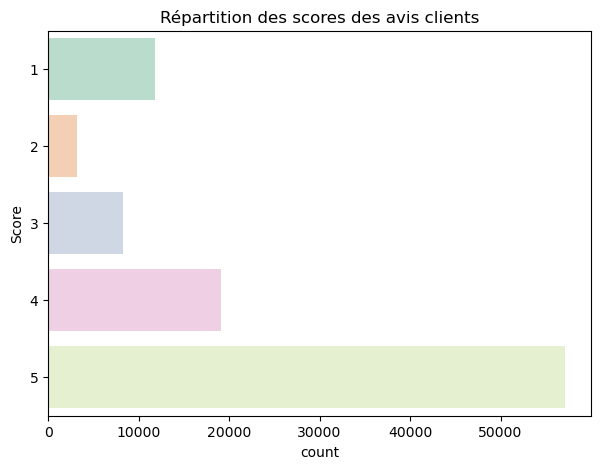

In [21]:
plt.figure(figsize=(7, 5))
sns.countplot(y="review_score", data=df_orders)
plt.title("Répartition des scores des avis clients")
plt.ylabel("Score")
plt.show()

La majorité des clients a attribué la note maximale à leurs commandes (5). Il y a peu d'avis négatif. 

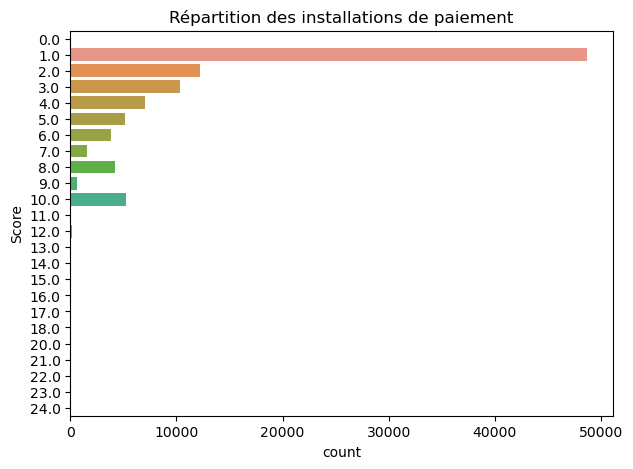

In [22]:
plt.figure(figsize=(7, 5))
sns.countplot(y="payment_installments", data=df_orders)
plt.title("Répartition des installations de paiement")
plt.ylabel("Score")
plt.show()

Une majorité des vendeurs ne dispose que d'une seule installation de paiement. Peu de vendeurs disposent de 9 à 10 installations. 

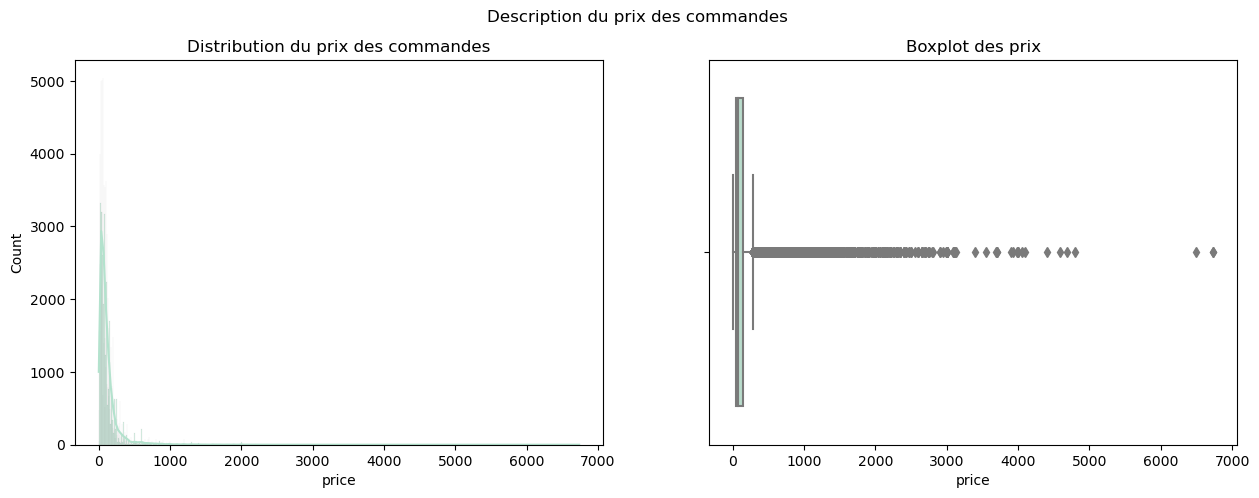

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du prix des commandes')

sns.histplot(ax=axes[0],x="price", data=df_orders, kde=True)
axes[0].set_title("Distribution du prix des commandes")

sns.boxplot(ax=axes[1], x="price", data=df_orders)
axes[1].set_title("Boxplot des prix")

plt.show()

Les commandes sont comprises entre 0 et 7000 Réaux brésiliens. Le prix des commandes ne semblent pas suivre une loi normale. 

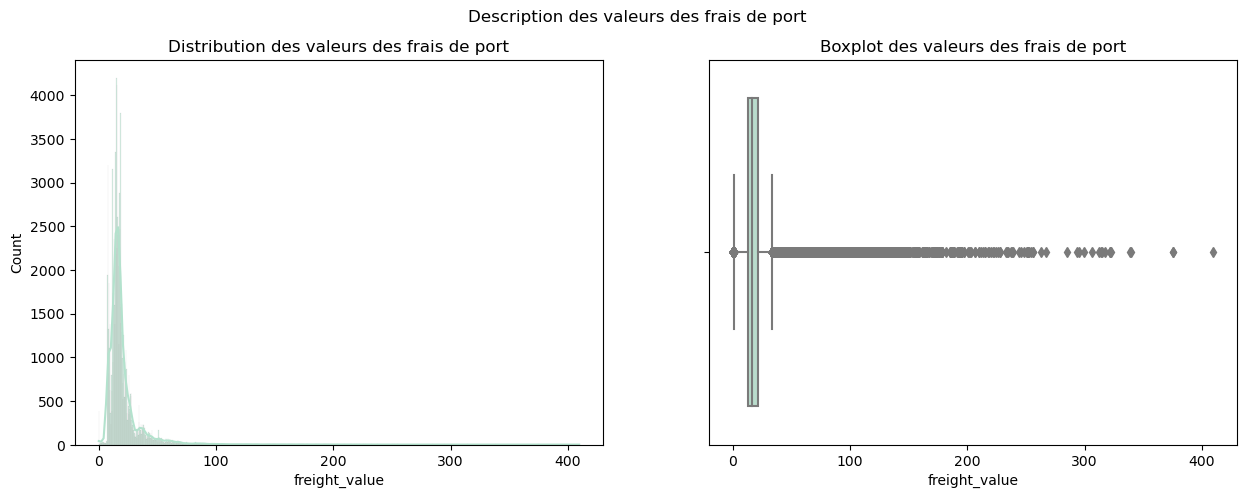

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des valeurs des frais de port')

sns.histplot(ax=axes[0],x="freight_value", data=df_orders, kde=True)
axes[0].set_title("Distribution des valeurs des frais de port")

sns.boxplot(ax=axes[1], x="freight_value", data=df_orders)
axes[1].set_title("Boxplot des valeurs des frais de port")

plt.show()

La valeur des frais de port ne suit pas une loi normale. Les frais de port sont compris entre 0 et 400 Réaux brésiliens. 

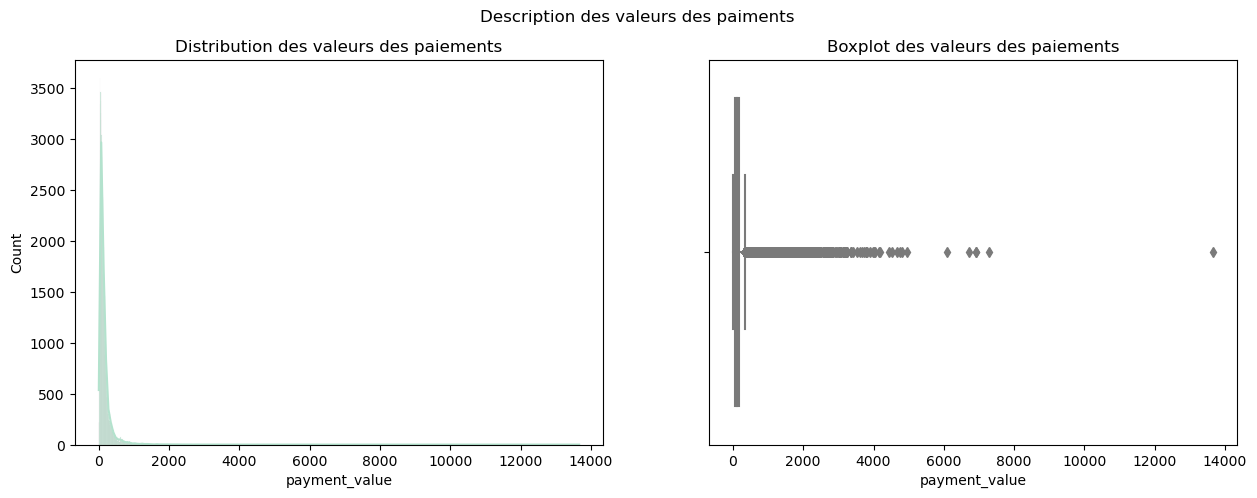

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des valeurs des paiments')

sns.histplot(ax=axes[0],x="payment_value", data=df_orders, kde=True)
axes[0].set_title("Distribution des valeurs des paiements")

sns.boxplot(ax=axes[1], x="payment_value", data=df_orders)
axes[1].set_title("Boxplot des valeurs des paiements")

plt.show()

La valeur maximale des paiements est de 14 000 Réaux brésiliens. 

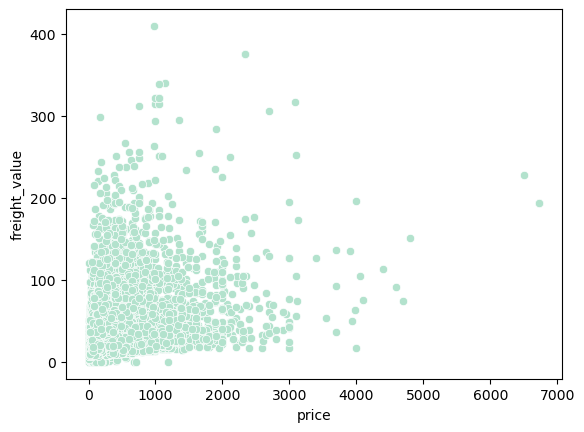

In [26]:
sns.scatterplot(x="price", y="freight_value", data=df_orders)
plt.show()

Il ne semble pas avoir de lien entre les prix des commandes et les frais de port. 

sns.pairplot(df_orders, hue="review_score")
plt.show()

Il ne semble pas avoir de lien entre les avis des clients et les montants associés à la commande. 

## 3 - Analyses des produits

In [27]:
df_products = pd.read_csv("datasets/olist_products_dataset.csv")
df_translation = pd.read_csv('datasets/product_category_name_translation.csv')

In [28]:
df_products = pd.merge(df_products, df_translation, on="product_category_name")
df_products.drop("product_category_name", axis=1, inplace=True)
df_products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


On a crée un dataset contenant les informations des produits vendus. On a associé la traduction des catégories. 

### Recherche de valeurs manquantes et de données dupliquées

In [29]:
df_products.isnull().mean()

product_id                       0.000000
product_name_lenght              0.000000
product_description_lenght       0.000000
product_photos_qty               0.000000
product_weight_g                 0.000031
product_length_cm                0.000031
product_height_cm                0.000031
product_width_cm                 0.000031
product_category_name_english    0.000000
dtype: float64

In [30]:
df_products.shape

(32328, 9)

In [31]:
df_products['product_id'].nunique()

32328

On observe quelques valeurs manquantes pour les caractéristiques physiques de produits (poids, longueurs, hauteurs, largeurs).

In [32]:
df_products[df_products.duplicated()]

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english


On n'a aucune valeur dupliquée sur ce jeu de données. 

### Descriptions des variables en lien avec les produits

In [33]:
df_products["product_category_name_english"].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'home_app

On observe une trentaine de catégories différentes de produits vendus. 

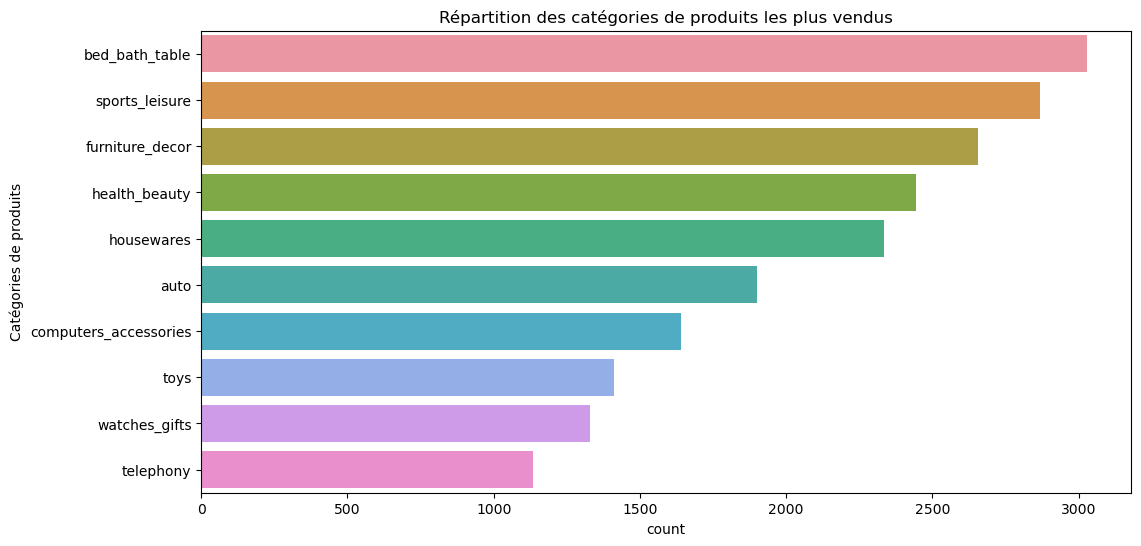

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(y="product_category_name_english", data=df_products, 
             order=df_products["product_category_name_english"].value_counts().index[:10])
plt.ylabel("Catégories de produits")
plt.title("Répartition des catégories de produits les plus vendus")
plt.show()

La catégorie la plus vendue est le linge de maison, suivie par les sports et loisirs et la décoration. 

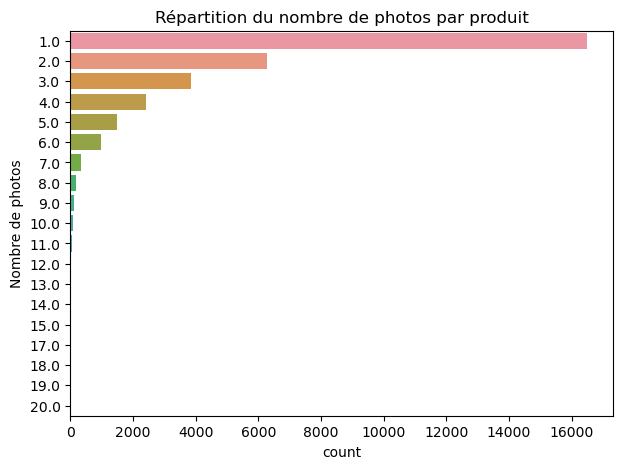

In [35]:
plt.figure(figsize=(7, 5))
sns.countplot(y="product_photos_qty", data=df_products)
plt.ylabel("Nombre de photos")
plt.title("Répartition du nombre de photos par produit")
plt.show()

En général, chaque produit est accompagné par une photo. Certains produits ont jusqu'à 11 photos. 

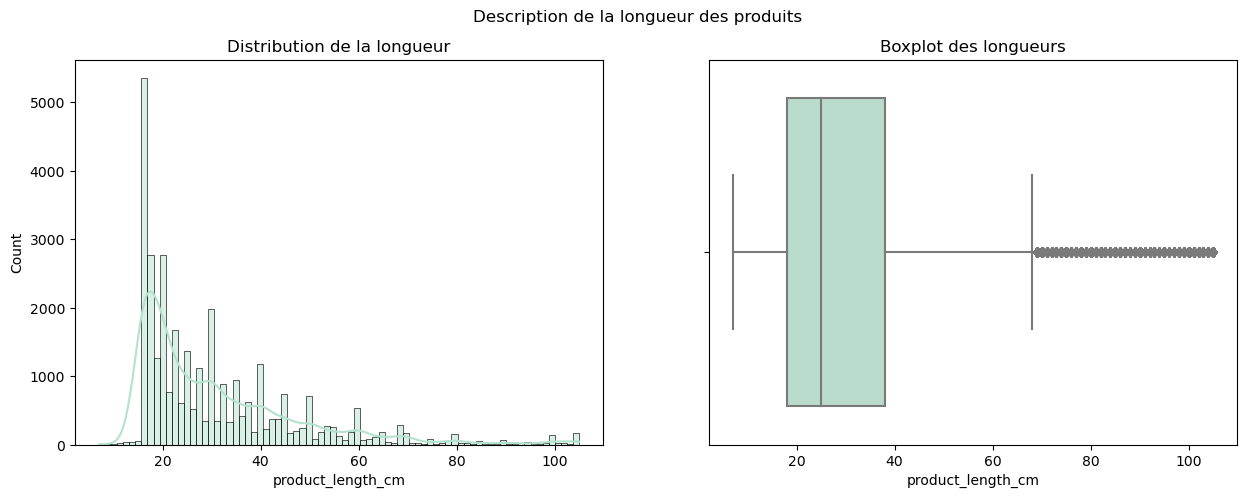

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la longueur des produits')

sns.histplot(ax=axes[0],x="product_length_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la longueur")

sns.boxplot(ax=axes[1], x="product_length_cm", data=df_products)
axes[1].set_title("Boxplot des longueurs")

plt.show()

La longueur des produits est comprise entre 0 et un peu plus de 100 cm. La majorité des produits a une longueur d'environ 20 cm.

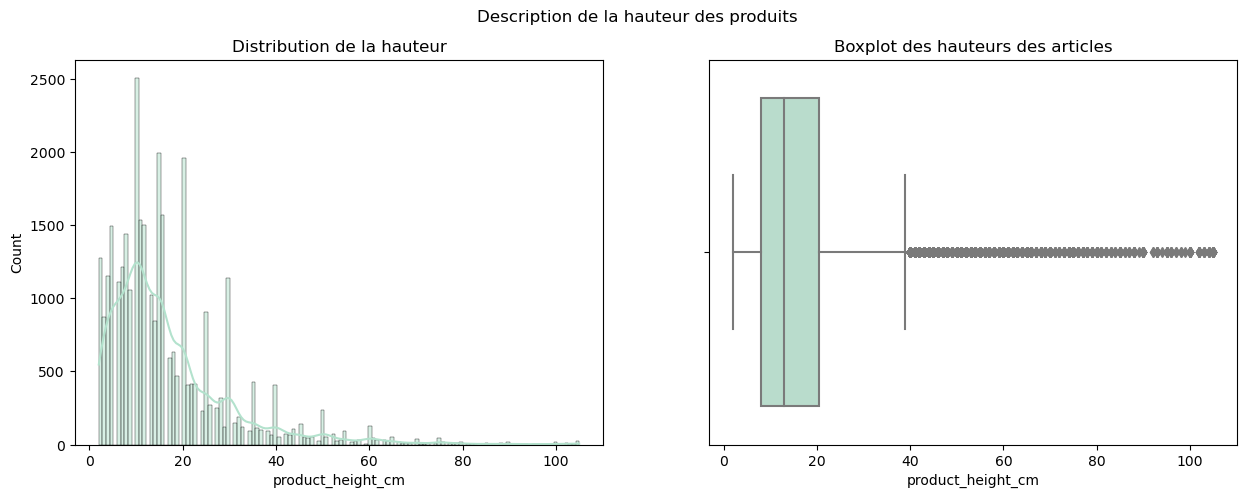

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la hauteur des produits')

sns.histplot(ax=axes[0],x="product_height_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la hauteur")

sns.boxplot(ax=axes[1], x="product_height_cm", data=df_products)
axes[1].set_title("Boxplot des hauteurs des articles")

plt.show()

La hauteur des produit se situe entre 0 et un peu plus de 100 cm. La hauteur moyenne est comprise entre 15 et 20 cm.

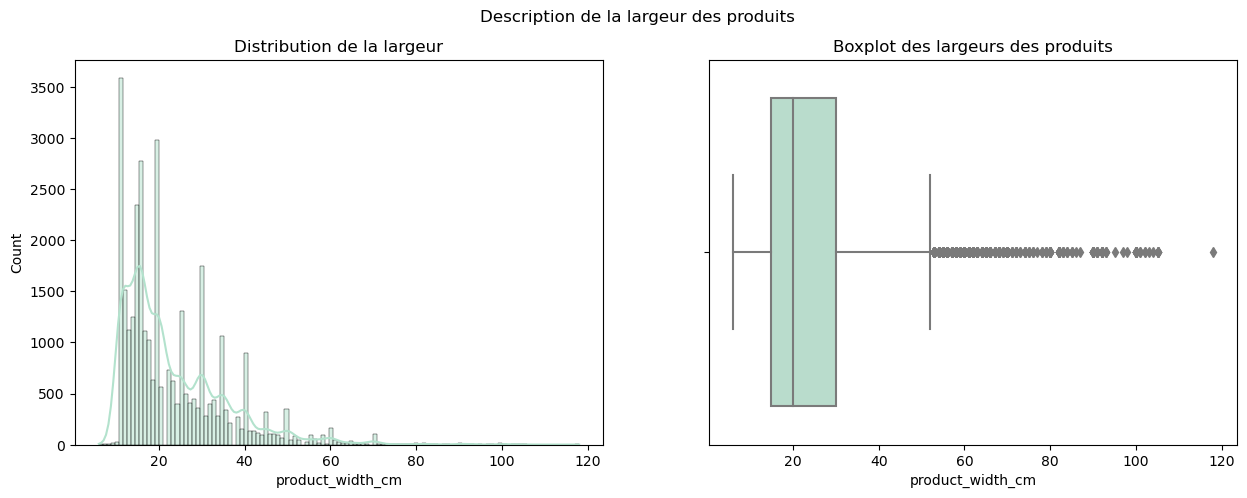

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la largeur des produits')

sns.histplot(ax=axes[0],x="product_width_cm", data=df_products, kde=True)
axes[0].set_title("Distribution de la largeur")

sns.boxplot(ax=axes[1], x="product_width_cm", data=df_products)
axes[1].set_title("Boxplot des largeurs des produits")

plt.show()

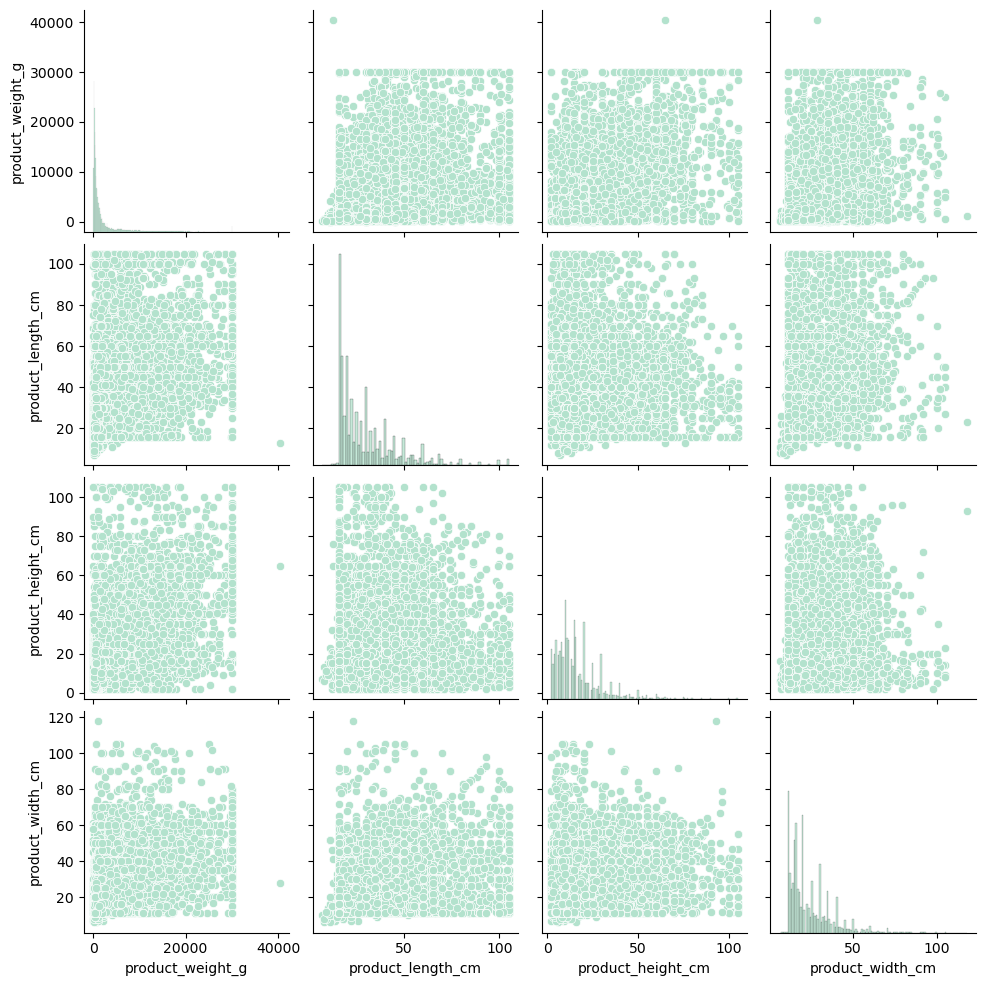

In [39]:
sns.pairplot(df_products[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']])
plt.show()

In [40]:
df_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32328.000000,32328.000000,32328.000000,32327.000000,32327.000000,32327.000000,32327.000000
mean,48.474078,771.520168,2.188815,2276.960807,30.856498,16.955950,23.208464
std,10.246388,635.180062,1.736746,4279.734063,16.958460,13.637246,12.080665
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,20.500000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


## 4 - Analyse des vendeurs

In [41]:
df_sellers = pd.read_csv("datasets/olist_sellers_dataset.csv")

In [42]:
df_sellers = pd.merge(df_geo, df_sellers,
                        right_on=["seller_zip_code_prefix", "seller_city", "seller_state"], 
                        left_on=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], how="right")
df_sellers.drop(["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], axis=1, inplace=True)
df_sellers = df_sellers[['seller_id', "seller_zip_code_prefix", "seller_city", "seller_state", "geolocation_lat", "geolocation_lng"]]
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.898536,-47.063125
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.895499,-47.061944
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.891740,-47.060820
3,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.895762,-47.066144
4,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.896154,-47.062431


In [43]:
df_sellers.isnull().mean()

seller_id                 0.000000
seller_zip_code_prefix    0.000000
seller_city               0.000000
seller_state              0.000000
geolocation_lat           0.000355
geolocation_lng           0.000355
dtype: float64

In [44]:
df_sellers.drop_duplicates(subset="seller_id", inplace=True)

In [45]:
df_sellers.shape

(3095, 6)

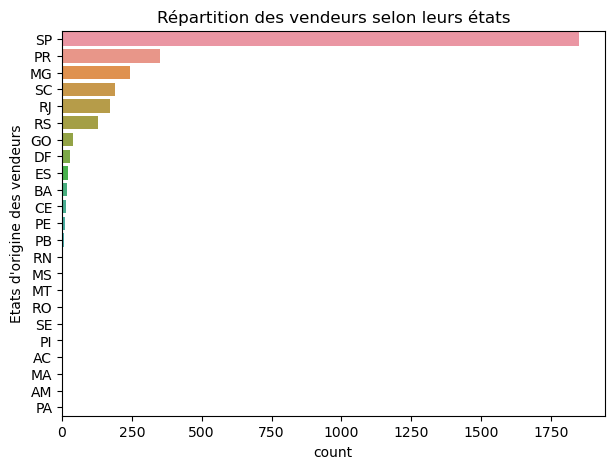

In [46]:
plt.figure(figsize=(7,5))
sns.countplot(y="seller_state", data=df_sellers, order=df_sellers["seller_state"].value_counts().index)
plt.title("Répartition des vendeurs selon leurs états")
plt.ylabel("Etats d'origine des vendeurs")
plt.show()

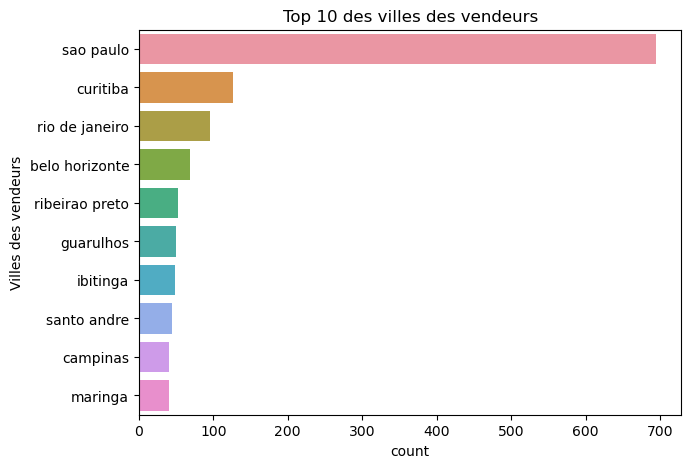

In [47]:
plt.figure(figsize=(7,5))
sns.countplot(y="seller_city", data=df_sellers, order=df_sellers["seller_city"].value_counts().index[:10])
plt.title("Top 10 des villes des vendeurs")
plt.ylabel("Villes des vendeurs")
plt.show()

In [48]:
print("Nombre d'id seller :", df_sellers["seller_id"].nunique())

Nombre d'id seller : 3095


In [49]:
print("Nombre de villes:", df_sellers["seller_city"].nunique())

Nombre de villes: 611


On enregistre 3095 vendeurs répartis dans 611 villes différentes. La ville qui comptabilise le plus de vendeurs est Sao Paolo suivie par Curitiba. On remarque que la plupart des vendeurs se situent dans l'état de Sao Paolo et de Minas Geiras.

## 5 - Analyses des produits et des ventes

In [50]:
df_prod_orders = pd.merge(df_products, df_orders, on="product_id", how="left")
df_prod_orders.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,...,5.0,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02,1.0,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,...,2.0,NaN,NaN,2017-12-14 00:00:00,2017-12-17 02:57:05,1.0,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,...,5.0,NaN,O produto que chegou é mais bonito do que eu e...,2017-11-24 00:00:00,2017-11-24 18:34:45,1.0,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,a84a0bd528e053f6b266e21bb1111e3f,...,5.0,Muito bom !!,Recomendo tanto o site lannister quanto a loja...,2018-07-11 00:00:00,2018-07-11 10:06:10,1.0,620c87c171fb2a6dd6e8bb4dec959fc6,2018-07-09 20:31:35,319.90,15.45
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,...,5.0,NaN,ótimo produto e ótima loja para comprar pelo s...,2017-08-09 00:00:00,2017-08-09 19:30:09,1.0,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13


In [51]:
df_prod_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98289 entries, 0 to 98288
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     98289 non-null  object 
 1   product_name_lenght            98289 non-null  float64
 2   product_description_lenght     98289 non-null  float64
 3   product_photos_qty             98289 non-null  float64
 4   product_weight_g               98288 non-null  float64
 5   product_length_cm              98288 non-null  float64
 6   product_height_cm              98288 non-null  float64
 7   product_width_cm               98288 non-null  float64
 8   product_category_name_english  98289 non-null  object 
 9   order_id                       97226 non-null  object 
 10  customer_id                    97226 non-null  object 
 11  order_status                   97226 non-null  object 
 12  order_purchase_timestamp       97226 non-null 

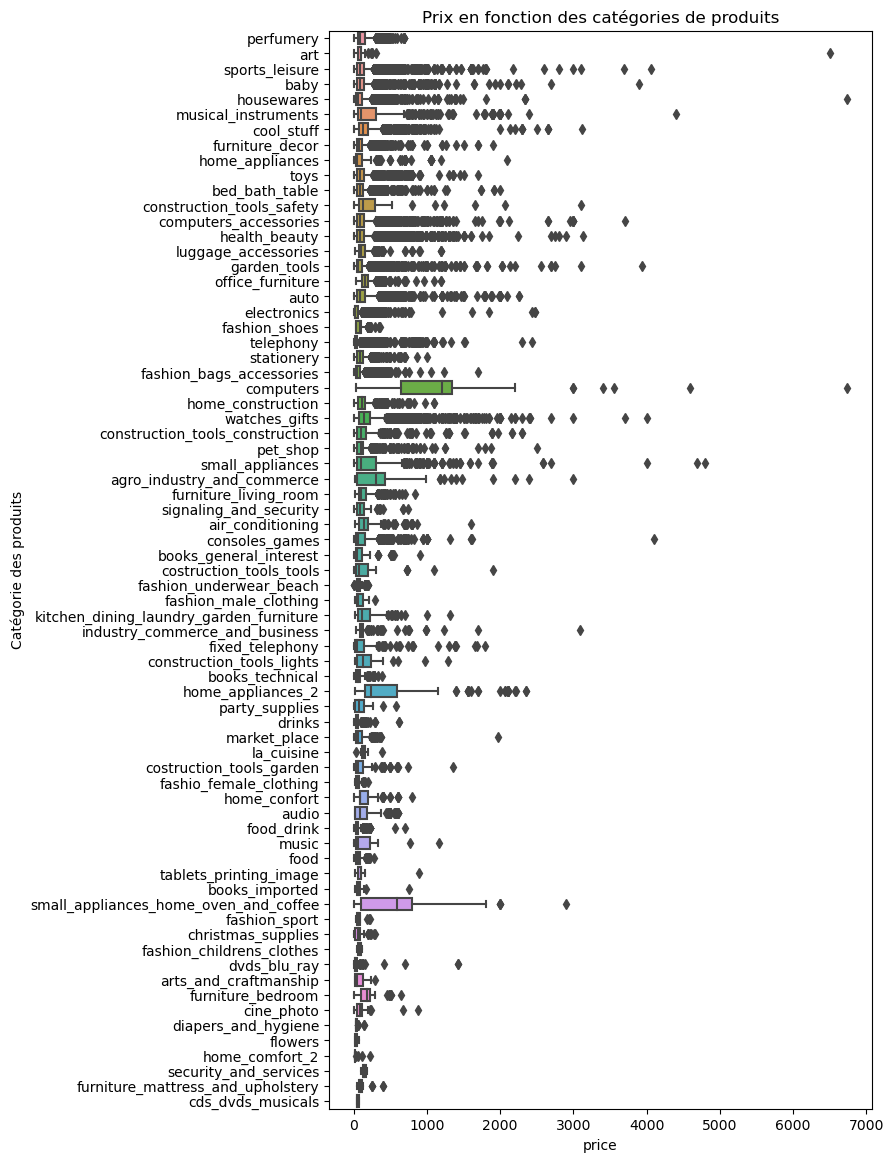

In [52]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="price", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Prix en fonction des catégories de produits")
plt.show()

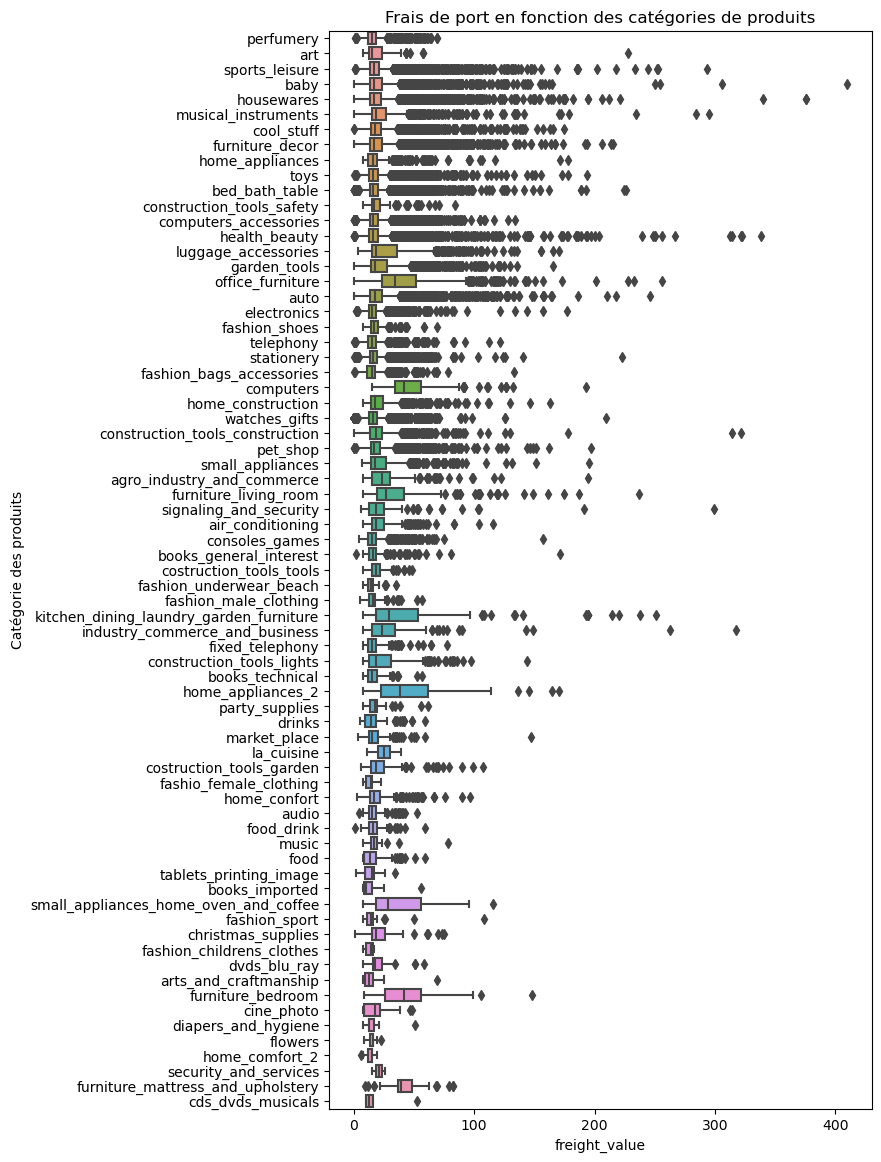

In [53]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="freight_value", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Frais de port en fonction des catégories de produits")
plt.show()

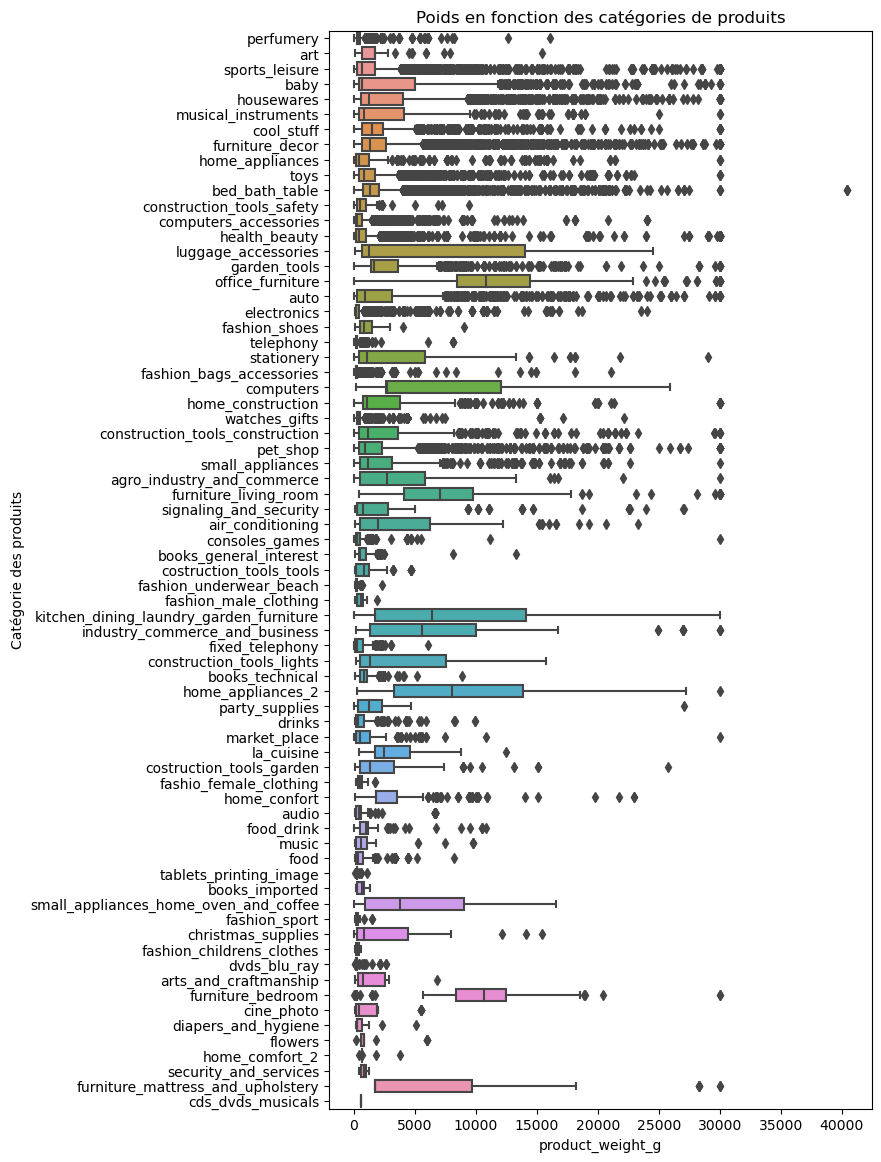

In [54]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_weight_g", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Poids en fonction des catégories de produits")
plt.show()

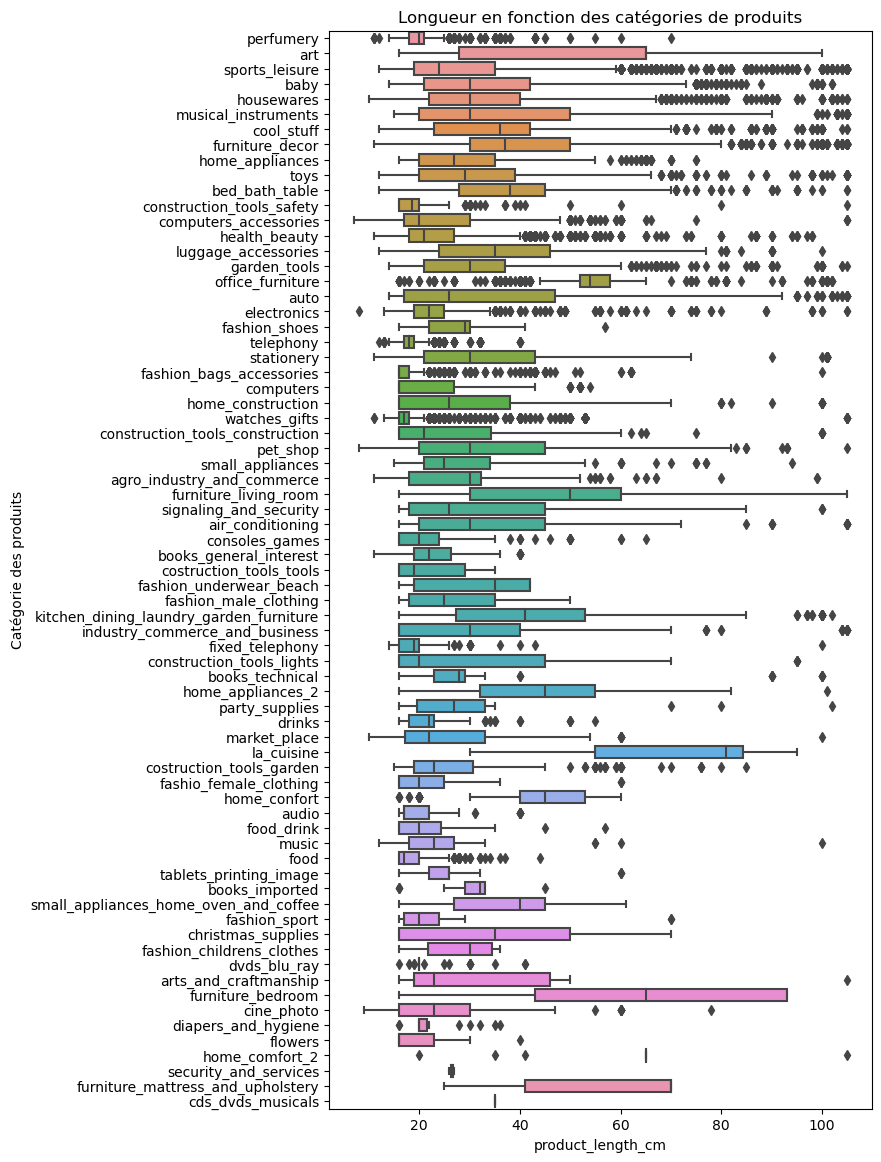

In [55]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_length_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Longueur en fonction des catégories de produits")
plt.show()

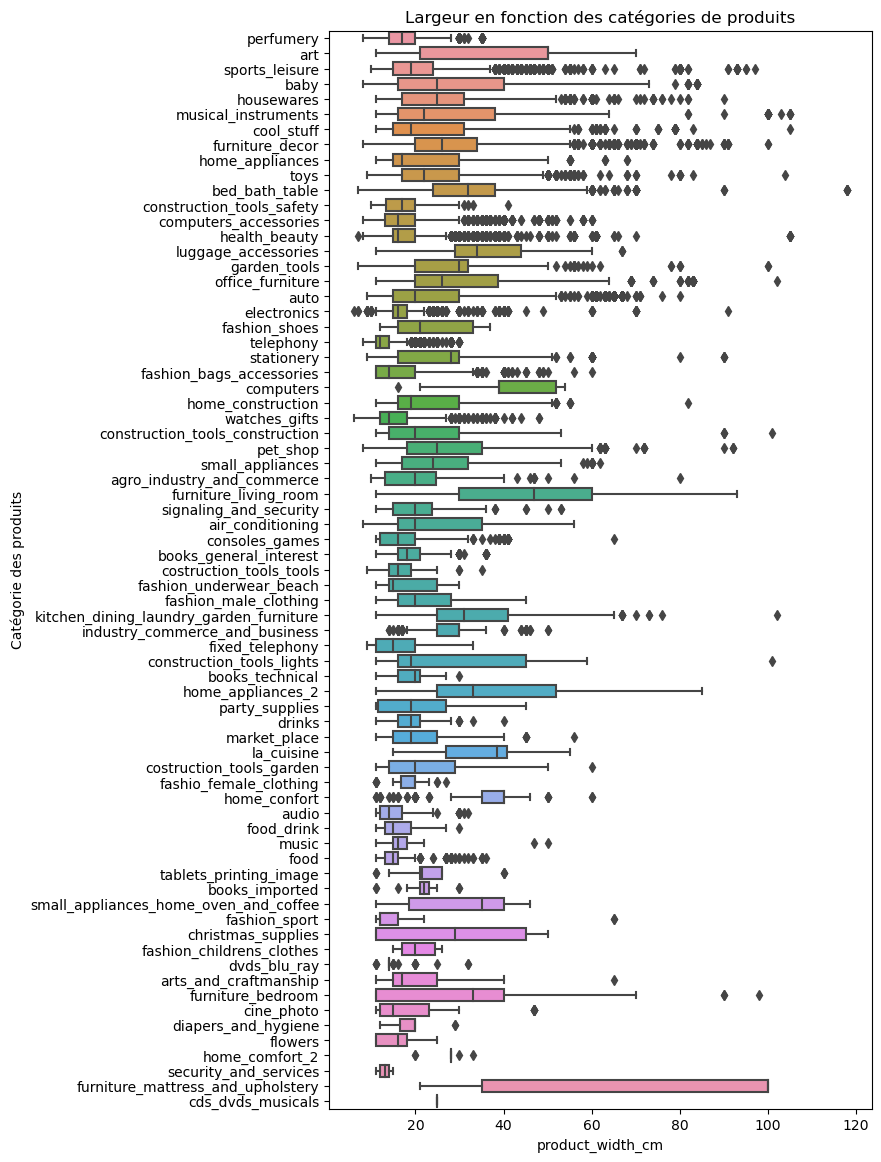

In [56]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_width_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Largeur en fonction des catégories de produits")
plt.show()

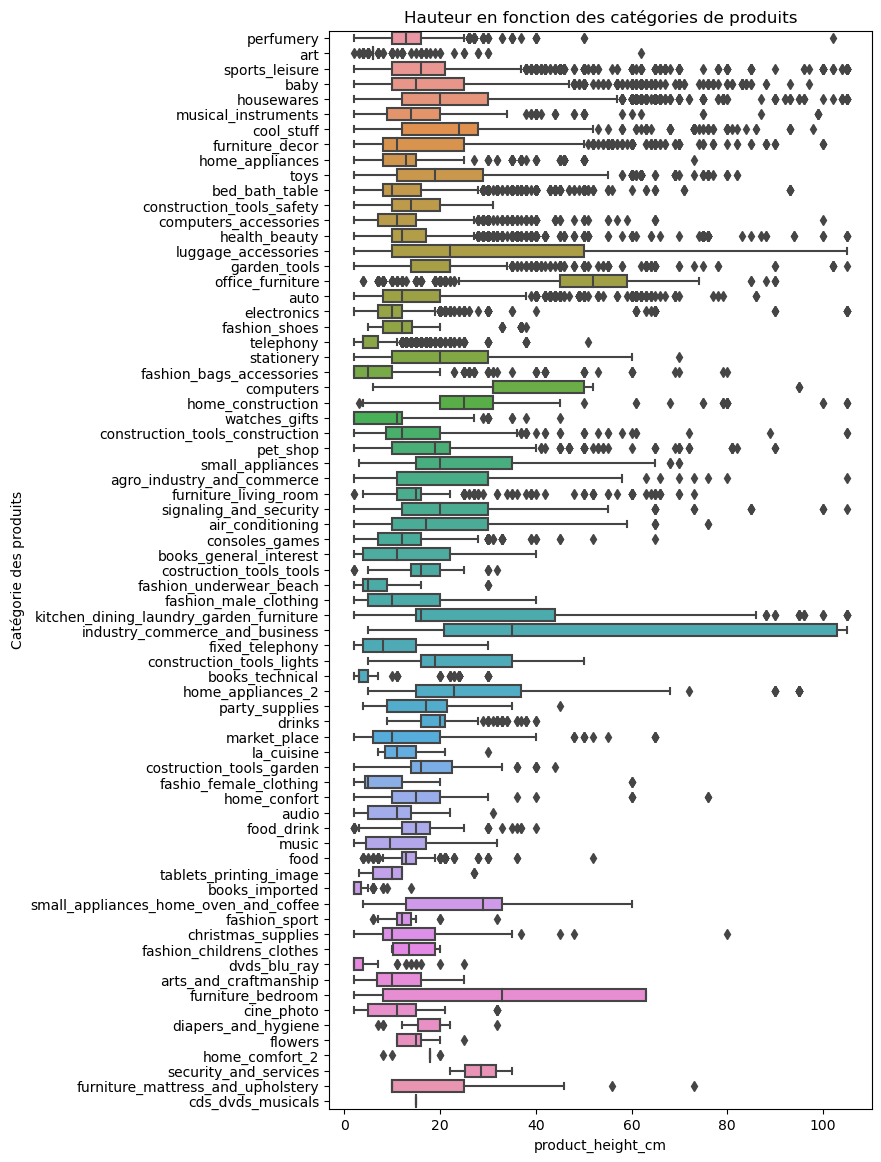

In [57]:
plt.figure(figsize=(7, 14))
sns.boxplot(x="product_height_cm", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Hauteur en fonction des catégories de produits")
plt.show()

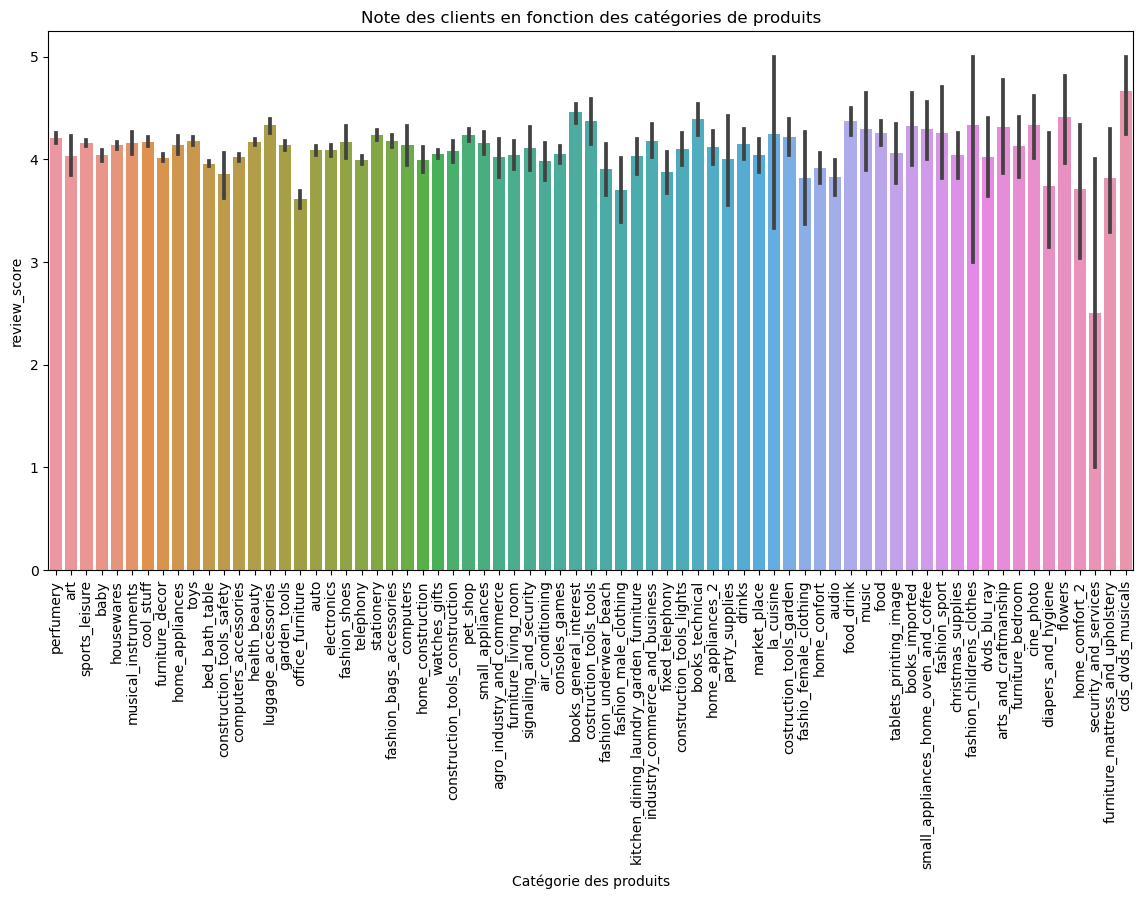

In [58]:
plt.figure(figsize=(14, 7))
sns.barplot(x="product_category_name_english", y="review_score", data=df_prod_orders)
plt.xlabel("Catégorie des produits")
plt.xticks(rotation=90)
plt.title("Note des clients en fonction des catégories de produits")
plt.show()

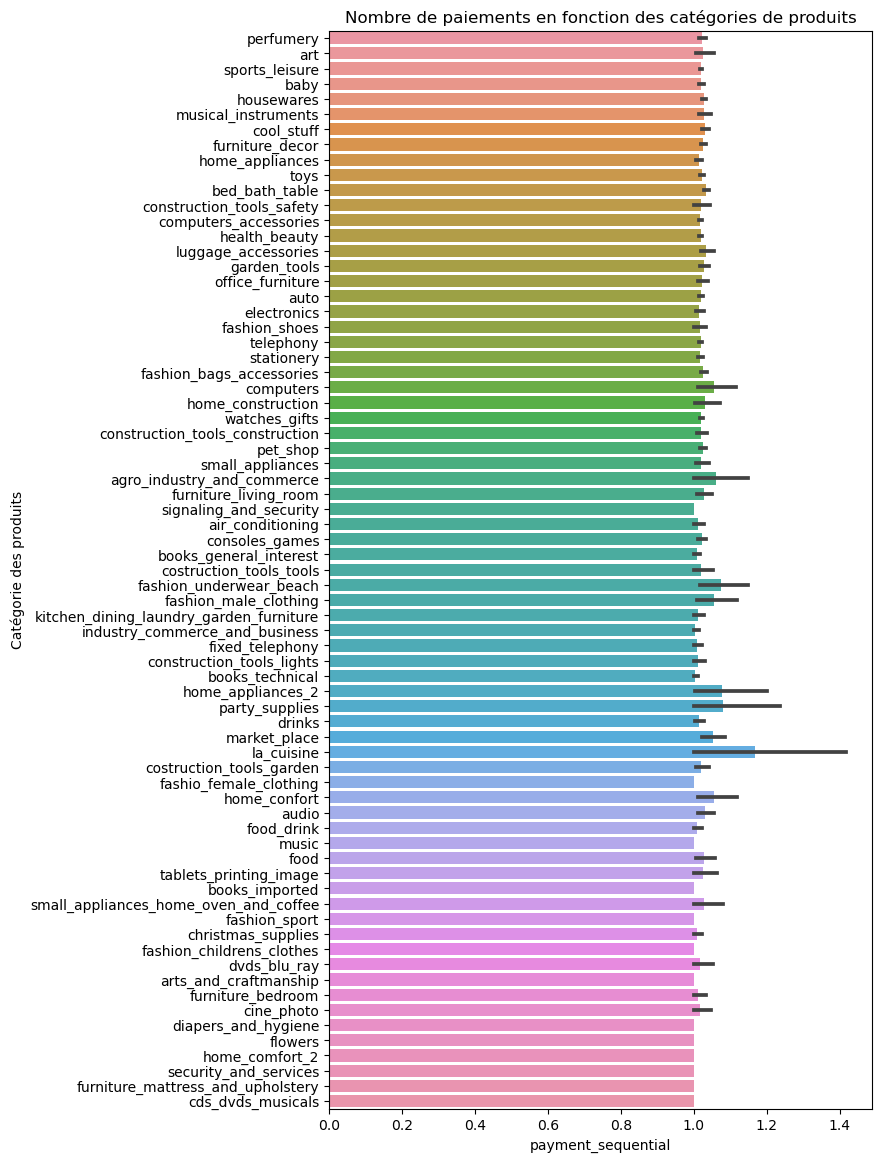

In [59]:
plt.figure(figsize=(7, 14))
sns.barplot(x="payment_sequential", y="product_category_name_english", data=df_prod_orders)
plt.ylabel("Catégorie des produits")
plt.title("Nombre de paiements en fonction des catégories de produits")
plt.show()

### 6 - Création de la segmentation RFM

In [60]:
df_prod_orders.drop(['product_name_lenght','product_description_lenght', 'product_photos_qty', "product_weight_g", "product_length_cm", "product_height_cm",
                    "product_width_cm", "order_purchase_timestamp", "order_estimated_delivery_date", "payment_installments", "review_id",
                    "review_comment_title", "review_comment_message", "order_item_id", "shipping_limit_date"], axis=1, inplace=True)

In [122]:
df_customers = pd.read_csv("datasets/olist_customers_dataset.csv")

In [123]:
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")

In [124]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [125]:
df = pd.merge(df_customers, df_orders, on="customer_id", how="right")
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [126]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [127]:
time = ["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols], format="%Y-%m-%d", errors="ignore")

In [128]:
snapshot_date = max(df.order_approved_at) + datetime.timedelta(days=1)

In [113]:
#df.dropna(inplace=True)

In [129]:
rfm_custom = df.groupby("customer_id").agg({
    "order_approved_at" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count'
})

In [130]:
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]

In [131]:
data = rfm_custom.copy()

## 7 - Analyse des comportements clients

In [132]:
data.sort_values("Frequency", ascending=False)

,Recency,Frequency
customer_id,,
00012a2ce6f8dcda20d059ce98491703,294.0,1
aa62a16b10e3fb24ecdefd7e4dc3fa65,72.0,1
aa738cdb72af39e38482fa25b992c67c,175.0,1
aa7210736aad65a84e964cfa8d64aa66,159.0,1
aa72002446dfbac0691304465c1b982d,567.0,1
...,...,...
5591abc9e7f9c644e7e7912aac65b718,245.0,1
5590e685a78102fb3ac27ecf07412750,315.0,1
558ea29f4c4dfd014345b6d3309549a2,235.0,1


In [ ]:
data.describe()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0],x="MonetaryValue", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0],x="Recency", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()